# 0.0 Imports

In [1]:
import math
import inflection
import datetime

import numpy     as np
import pandas    as pd
import seaborn   as sns

from scipy                import stats  as ss
from matplotlib           import pyplot as plt
from IPython.core.display import HTML
from IPython.display      import Image
from tabulate             import tabulate

## 0.1 Helper Functions

In [2]:
def personal_settings(): 
    
    # notbook
    display(HTML('<style>.container{width:98% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.options.display.float_format = '{:.2f}'.format
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(22,10)})
    sns.set_theme(style = 'darkgrid', font_scale = 1.2)
    #sns.set_palette('viridis_r')
    
    return None

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min( kcorr-1, rcorr-1 )))


In [3]:
personal_settings()

## 0.2 Load  Data

In [4]:
df_sales_raw = pd.read_csv('data/raw/train.csv', low_memory=False )
df_store_raw = pd.read_csv('data/raw/store.csv', low_memory=False )

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Data Description 

In [5]:
df1 = df_raw.copy()
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


## 1.1 Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
new_cols  = list(map(snakecase, old_cols))

# rename
df1.columns = new_cols

df1.rename(columns={'promo': 'is_promo', 'promo2': 'promo2_participant', 'promo_interval':'promo2_interval'},  inplace = True)
df1.columns 

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open',
       'is_promo', 'state_holiday', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2_participant',
       'promo2_since_week', 'promo2_since_year', 'promo2_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print(df1.shape[0], 'rows')
print(df1.shape[1], 'columns')

1017209 rows
18 columns


## 1.3 Data Types

In [9]:
description = []

for i in df1.columns:
    description.append([
        i,
        df1[i].dtypes,
        df1[i].nunique(),
        df1[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data=description, columns=['attributes', 'dtypes', 'nunique', 'sample'])

,attributes,dtypes,nunique,sample
0,store,int64,1115,"[695, 293]"
1,day_of_week,int64,7,"[6, 5]"
2,date,object,942,"[2014-06-04, 2013-06-20]"
3,sales,int64,21734,"[21237, 837]"
4,customers,int64,4086,"[2575, 1837]"
5,open,int64,2,"[0, 1]"
6,is_promo,int64,2,"[1, 0]"
7,state_holiday,object,4,"[0, c]"
8,school_holiday,int64,2,"[0, 1]"
9,store_type,object,4,"[a, d]"


## 1.4 Check NA

In [10]:
description = []
for i in df1.columns:
    description.append([
        i,
        df1[i].isna().sum(),
        round((df1[i].isna().sum()/len(df1))*100)
    ])

pd.DataFrame(data=description, columns=['attributes','null', '%null'])

,attributes,null,%null
0,store,0,0
1,day_of_week,0,0
2,date,0,0
3,sales,0,0
4,customers,0,0
5,open,0,0
6,is_promo,0,0
7,state_holiday,0,0
8,school_holiday,0,0
9,store_type,0,0


## 1.5 Fillout NA

To fill in the missing values, we will make some business assumptions. 

For 'competition_distance' we will assume that the closest competitor is so far away that there is no competitor, so to fill in this missing data, we will use a value much higher than the maximum value in 'competition_distance'.

In [11]:
# 'competition_distance'

max_dist = df1['competition_distance'].max()

new_max_dist = max_dist * 1.5

print('Max distance:', max_dist)
print('New Max distance:', new_max_dist)

# fill NAs
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: new_max_dist if math.isnan(x) else x)

Max distance: 75860.0
New Max distance: 113790.0


For 'competition_open_since_month' and 'competition_open_since_year', let's assume two reasons why those columns are empty, the store has no nearest competitor, or the store has a nearby competitor but we don't know when it opened (either because it opened much earlier than the store, or because it opened later and someone forgot to write it down).

If the 'competition_open_since_month' is NA we will copy the sale date of that line to 'competition_open_since_month'. With this reasoning, we are thinking one step ahead (feature engineering). There are some variables that we derive from time that are very important, to represent the behavior. One of them is "how long has it been since an event happened".

In this sale, how long has it been since I had an open competition? 
If you have a store and it has no close competitor, you have a certain amount of sales, when a close competition opens up, those sales tend to drop, because the customers split up. When that competition gets more mature, sales grow again, but they don't stay at the same level as before you had a competitor. We don't know if it will work, but we will test it in the first CRISP cycle.

The same reasoning applies to 'competition_open_since_year'.

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

# 'competition_open_since_month' and 'competition_open_since_year'
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year']  = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'] , axis=1)

For 'promo2_since_week' and 'promo2_since_year', to fillout the missing values, we will use the same reasoning used in 'competition_open_since_month' and 'competition_open_since_year'.

In [13]:
# promo2_since_week and 'promo2_since_year'
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1).astype('int64')
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1).astype('int64')

In [14]:
# 'promo_interval' 

# creating a dictionary to replace the number of the month (which I will extract from date) with the name
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

# replacing every NA in 'promo_inteval' with 0, because these are stores that did not participate in the promotion
df1['promo2_interval'].fillna(0, inplace=True)

# extracting the month from date with 'month_map'
df1['month_map'] = df1['date'].dt.month.map(month_map)

# variable to tell if the purchase happened on a promotion
df1['is_promo2'] = df1[['promo2_interval', 'month_map']].apply(lambda x: 0 if x['promo2_interval'] == 0 else 
                                                                         1 if x['month_map'] in x['promo2_interval'].split(',') else 0, axis=1)

In [15]:
df1[['date', 'promo2_interval', 'month_map', 'is_promo2']].sample(5).T

,1016416,146728,115493,745944,53937
date,2013-01-01 00:00:00,2015-03-22 00:00:00,2015-04-19 00:00:00,2013-09-01 00:00:00,2015-06-13 00:00:00
promo2_interval,"Jan,Apr,Jul,Oct",0,0,"Mar,Jun,Sept,Dec","Feb,May,Aug,Nov"
month_map,Jan,Mar,Apr,Sep,Jun
is_promo2,1,0,0,0,0


In [16]:
description = []
for i in df1.columns:
    description.append([
        i,
        df1[i].isna().sum(),
        round((df1[i].isna().sum()/len(df1))*100)
    ])

pd.DataFrame(data=description, columns=['attributes','null', '%null'])

,attributes,null,%null
0,store,0,0
1,day_of_week,0,0
2,date,0,0
3,sales,0,0
4,customers,0,0
5,open,0,0
6,is_promo,0,0
7,state_holiday,0,0
8,school_holiday,0,0
9,store_type,0,0


## 1.6 Change Data Types

In [17]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype('int64')

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistics

In [18]:
df_num1 = df1.select_dtypes(include = ['int64', 'float64'])
df_cat1 = df1.select_dtypes(exclude = ['int64', 'float64'])

### 1.7.1 Numerical Attributes

In [19]:
# central tendency - mean, median
ct1 = pd.DataFrame(df_num1.apply(np.mean)).T
ct2 = pd.DataFrame(df_num1.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df_num1.apply(np.std)).T 
d2 = pd.DataFrame(df_num1.apply(min)).T
d3 = pd.DataFrame(df_num1.apply(max)).T
d4 = pd.DataFrame(df_num1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df_num1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df_num1.apply(lambda x: x.kurtosis())).T

# concat
num1_summary = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num1_summary.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
num1_summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,is_promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,113790.00,113770.00,5711.53,2330.00,9475.73,5.37,47.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


In [20]:
df_num1.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes'})

,attributes,min,max,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,5773.82,5744.00,3849.93,0.64,1.78
3,customers,0.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,is_promo,0.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,113790.00,5711.53,2330.00,9475.74,5.37,47.79
8,competition_open_since_month,1.00,12.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,2010.32,2012.00,5.52,-7.24,124.07


### 1.7.2 Categorical Attributes

In [21]:
cat1_summary = df_cat1.astype('category').describe().T.drop(columns = 'count')
cat1_summary

,unique,top,freq
date,942,2014-04-17 00:00:00,1115
state_holiday,4,0,986159
store_type,4,a,551627
assortment,3,a,537445
promo2_interval,4,0,508031
month_map,12,Mar,103695


In [22]:
print('Date min:', df_cat1['date'].min())
print('Date max:', df_cat1['date'].max())

Date min: 2013-01-01 00:00:00
Date max: 2015-07-31 00:00:00


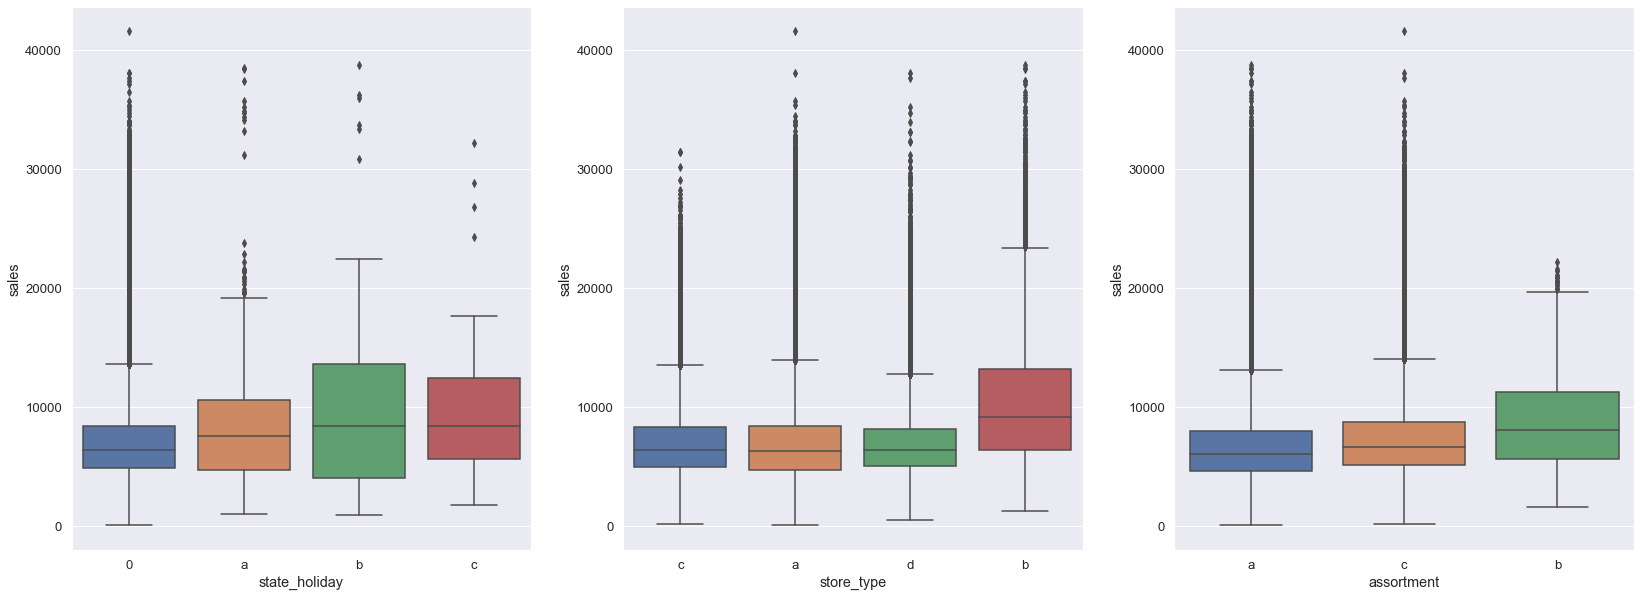

In [23]:
# how the sales are distributed within each of the state_holiday, store_type and assortment variables.
aux = df1[df1['sales'] > 0]

plt.figure(figsize=(28, 10))

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux)

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux)

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux);

# 2.0 Feature Engineering

In [24]:
df2 = df1.copy()

## 2.1 Hypotesis Mind Map

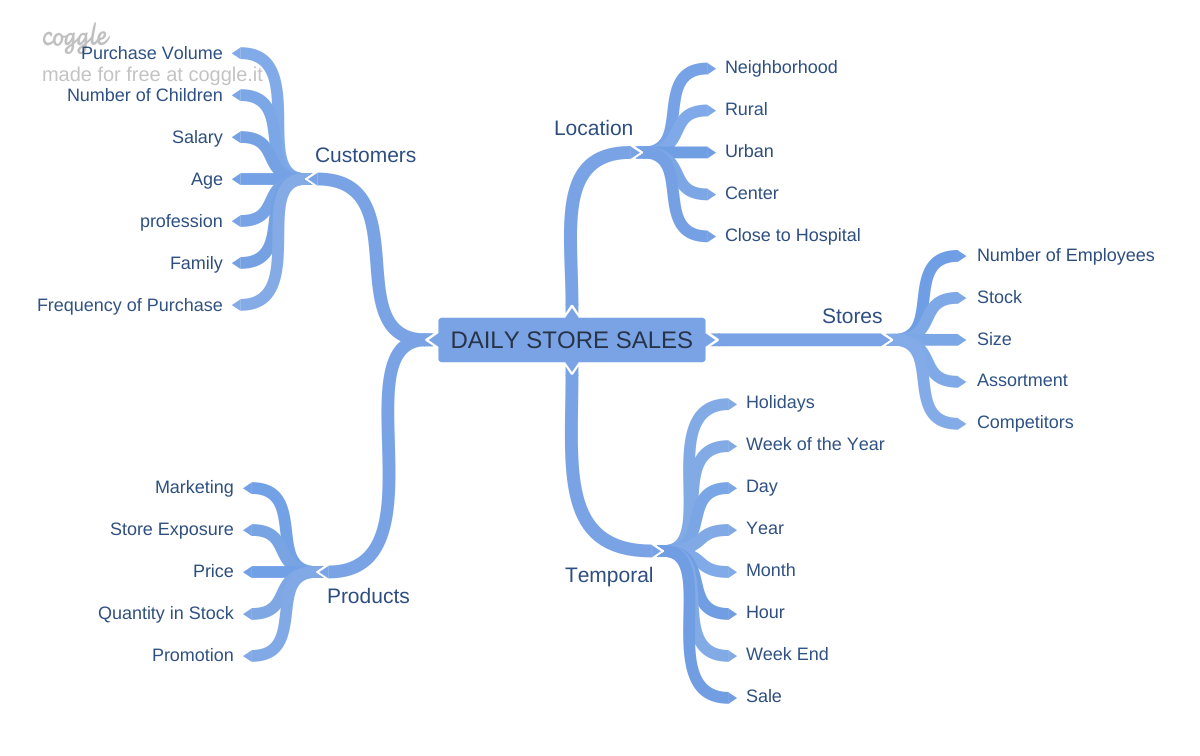

In [25]:
Image('images/mind_map.png')

## 2.2 Hypothesis List

**1.** On on average, stores with a wider assortment should sell more.  

**2.** On avarange, stores with closer competitors should sell less.   

**3.** Stores with long-term competitors (over 10 years) should sell more.   

**4.** On average, stores with active promotions should sell more.   

**5.** Stores with longer active promo2 should sell more.   

**6.** On average, stores that besides continued promotion, also are running another promotion, sell more than stores that are running only the continued promotion.  

**7.** Every year, stores open during the Christmas holiday are expected to sell more on average than during other holidays.   

**8.** Stores should sell more over years.    

**9.** Stores should sell more in the second half of the year.   

**10.** On avarange, stores should sell more after the 10th of each month.   

**11.** On avarange, stores should sell less on weekends.    

**12.** On avarange, stores should sell less during school holidays.     

## 2.4. Feature Engineering

In [26]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# creating 'competition_open_since' by combining 'competition_open_since_year' and 'competition_open_since_month'
df2['competition_open_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1).astype('int64')

# creating 'competition_time_month' by calculating the difference between 'date' and 'competition_open_since':
df2['competition_open_timein_months'] = ((pd.to_datetime(df2['date']).dt.date -  pd.to_datetime(df2['competition_open_since']).dt.date)/30).apply(lambda x: x.days).astype('int64')

# creating 'promo2_since' by 'combining promo2_since_year' and 'promo2_since_week'
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) 
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))  #t he -1 and -%w pattern tells the parser to pick the monday in that week

# creating 'promo2_since_timein_weeks' by calculating the difference between 'date' and 'promo2_since':
df2['promo2_since_timein_weeks'] = ((pd.to_datetime(df2['date']).dt.date - pd.to_datetime(df2['promo2_since']).dt.date)/7).apply(lambda x: x.days).astype('int64')

# changing assortment attribute by given classification
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# changing 'state_holiday' attribute by given classification
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 

# --- notes:
# strftime() - considers the first week of a year with a monday
# isocalender() - considers the first week of a year a thursday
# negative values for 'competition_open_timein_months' means that competitor openned after sales register
# negative values for promo2_since_timein_weeks means that promotion happened after sales register

# 3.0 Data Filtering

In [27]:
df3 = df2.copy()

## 3.1 Lines Filtering

In [28]:
# keep data only from days when the stores were open
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selections

In [29]:
# delete features that derived others and the 'open', since all lines have the same value
cols_drop = ['open', 'promo2_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

## 3.3 Training and Test Datasets

It may seem strange to voluntarily set aside some of the data at this stage. We certainly need to learn a lot more about it before deciding which algorithms to use  but our brain is an amazing pattern detection system, which means that it is highly prone to overfitting: if we look at the test set, we might stumble upon some seemingly interesting pattern in the test data that will lead us to select a particular type of Machine Learning model. When we estimate the generalization error using the test set, our estimate will be too optimistic, and we will not launch a system that will not work as well as expected, which is called data snooping bias.

Reference: Géron, A., 2019. Hands-on machine learning with Scikit-Learn and TensorFlow. 2nd ed. Sebastopol, CA: O'Reilly, p.51.

In [30]:
# Checking 'date' intervals

first_date = df3['date'].min()
last_date  = df3['date'].max()
sixweeks_before = last_date - datetime.timedelta(days=6*7)

print(first_date, '-> First date')
print(last_date,  '-> Last date' )
print(sixweeks_before, '-> Six weeks before last date')

2013-01-01 00:00:00 -> First date
2015-07-31 00:00:00 -> Last date
2015-06-19 00:00:00 -> Six weeks before last date


In [31]:
# Training Dataset
df_train = df3[df3['date'] <  sixweeks_before]

# Test Dataset
df_test = df3[df3['date'] >= sixweeks_before]

print(f"Training Min Date: {df_train['date'].min()}")
print(f"Training Max Date: {df_train['date'].max()}")
print()
print(f"Test Min Date: {df_test['date'].min()}")
print(f"Test Max Date: {df_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


Since the training and test sets depend on 'date' (greater or lesser than a certain date), there is no risk that when we run the program again, a different test set is generated, and over time, we and the algorithms see the whole dataset. 

# 4.0 Exploratory Data Analysis

In [32]:
df4 = df_train.copy()

In [33]:
df_num2 = df4.select_dtypes(include = ['int64', 'float64'])
df_cat2 = df4.select_dtypes(exclude = ['int64', 'float64'])

## 4.1. Univariate Analysis

## 4.1.1 Response Variable

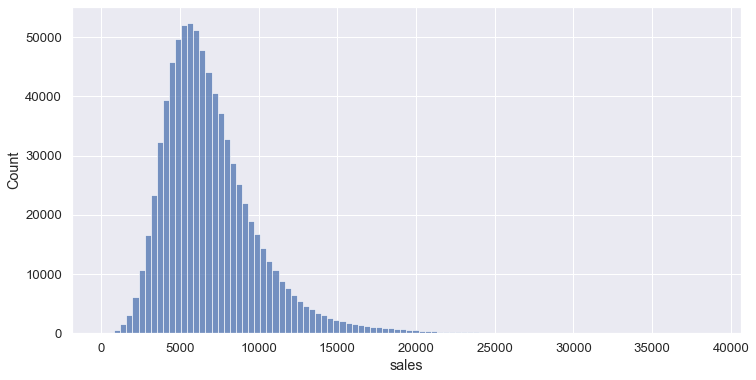

In [34]:
plt.figure(figsize=(12, 6))
sns.histplot(x='sales', bins= 100, data=df4);

### 4.1.2 Numerical Variable

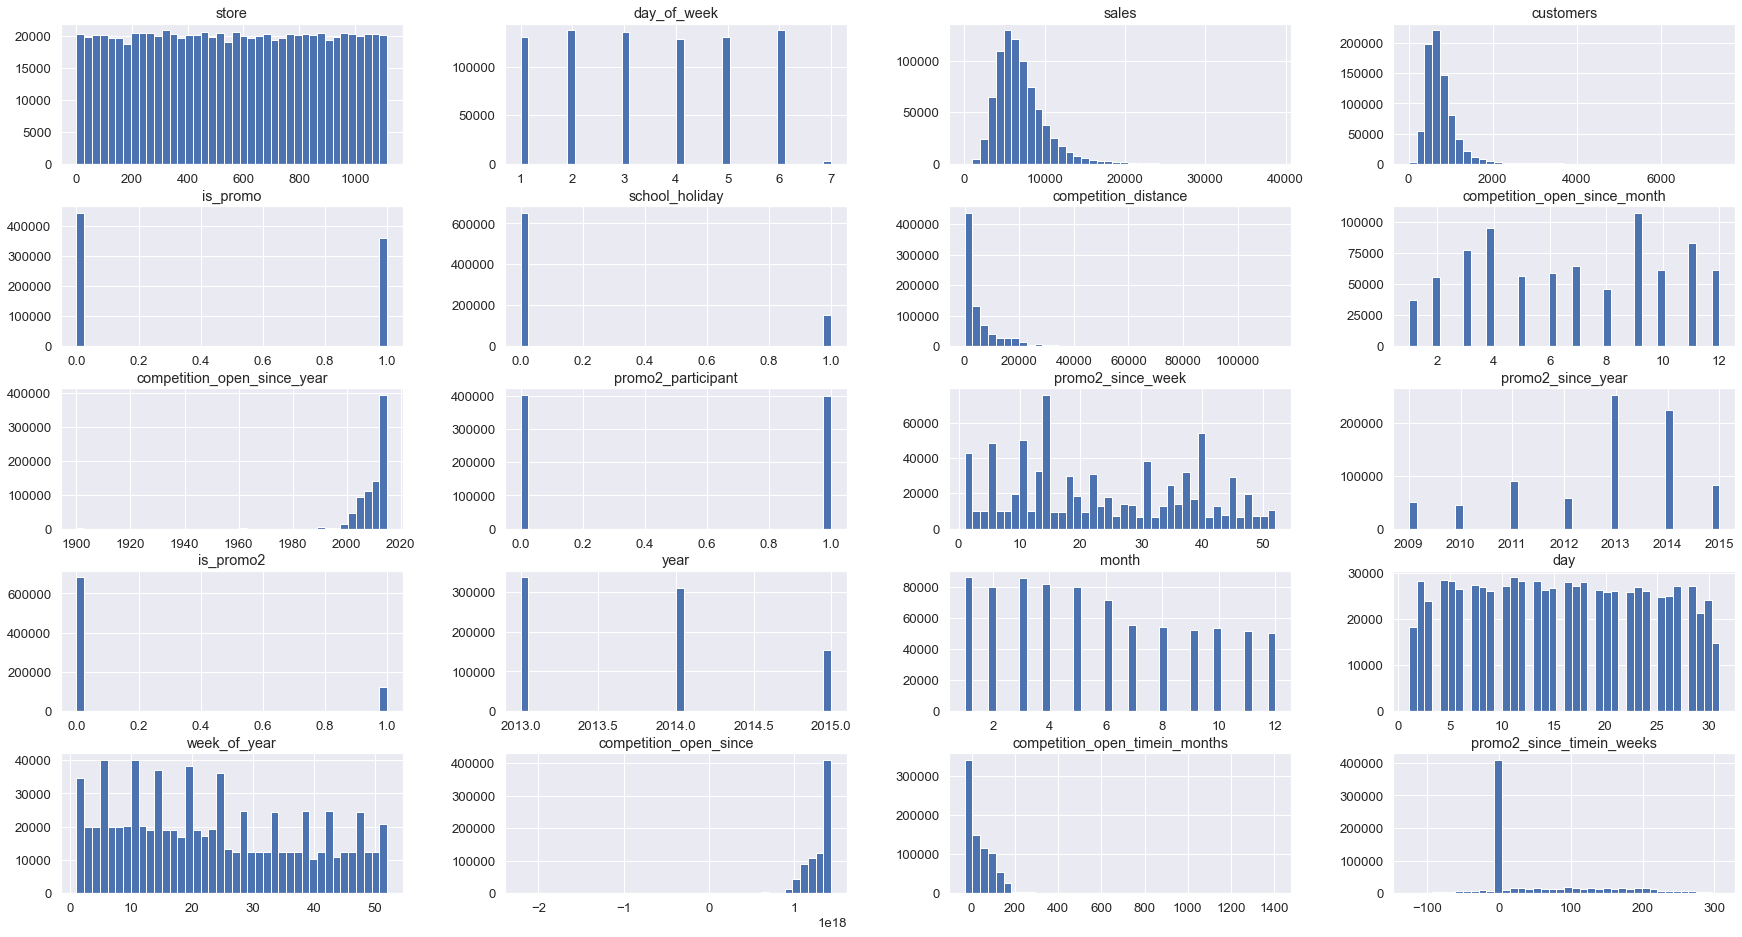

In [35]:
plt.rcParams['figure.figsize'] = [30, 16]
df_num2.hist(bins=40);

### 4.1.3 Categorical Variable

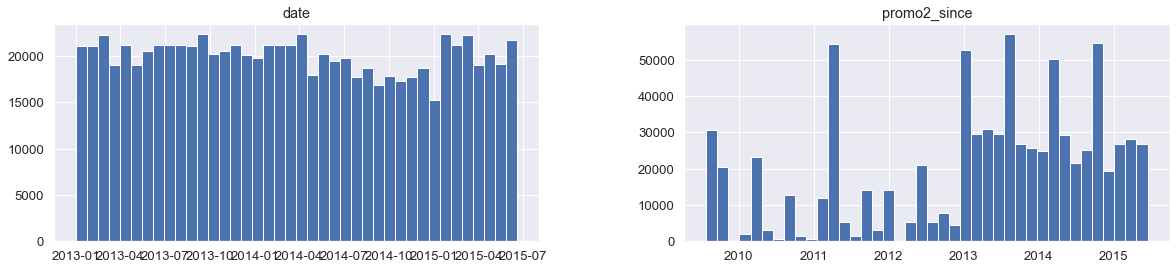

In [36]:
# histograms for date columns
plt.rcParams['figure.figsize'] = [20, 4]
df_cat2.hist(bins=40);

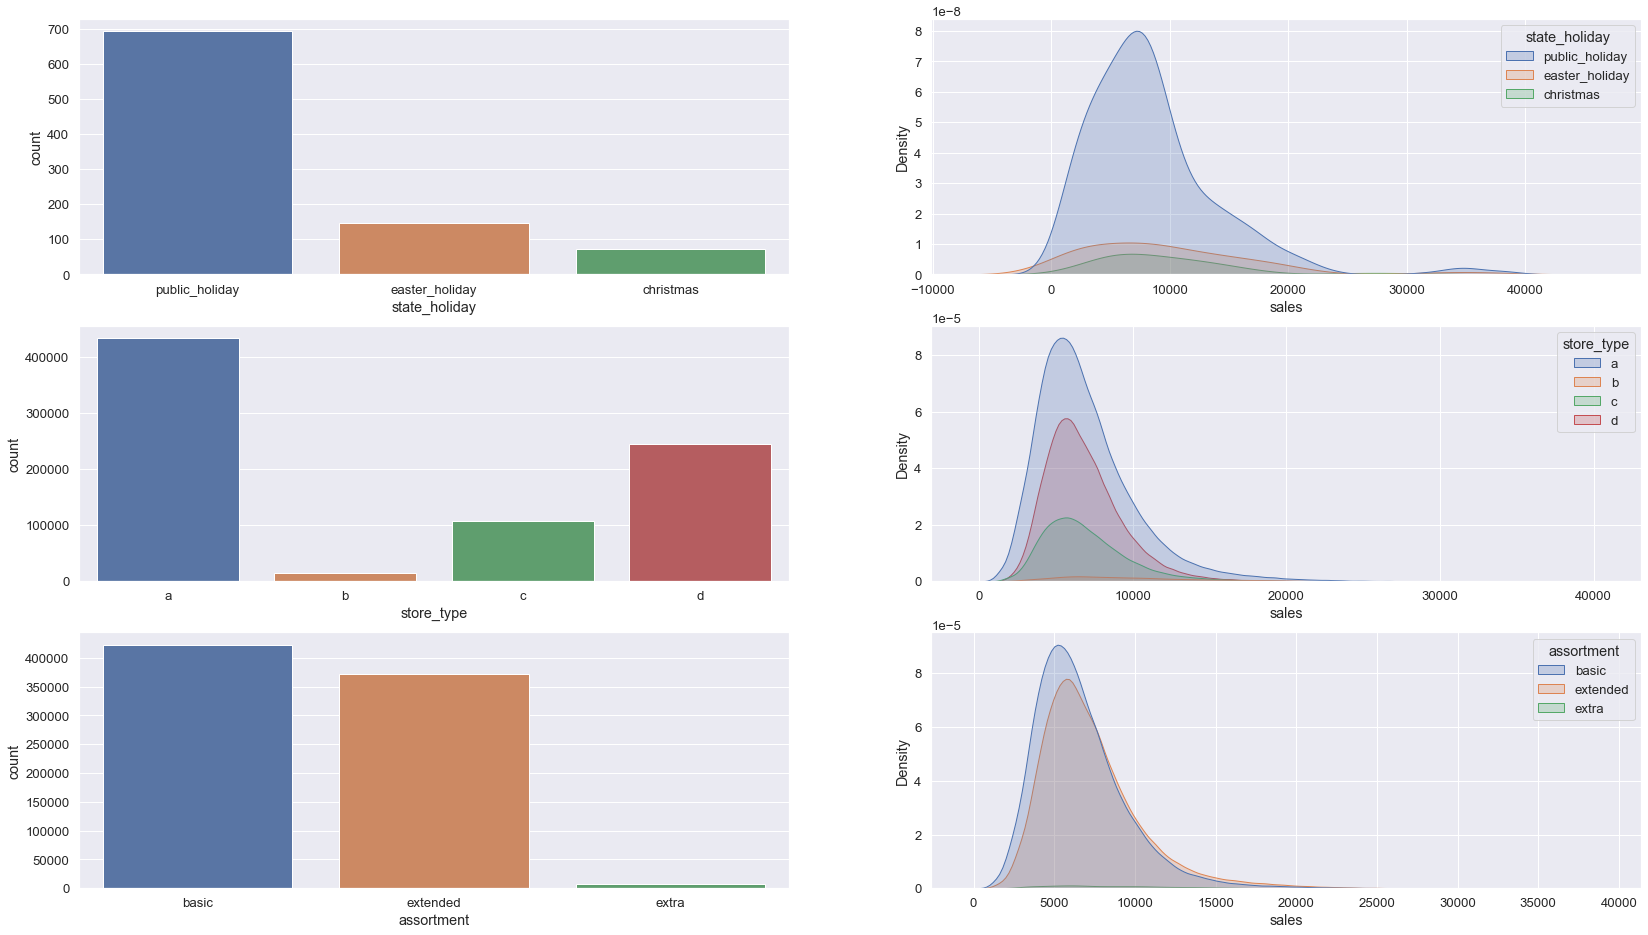

In [37]:
plt.figure(figsize= (28, 16))

# sales by 'state_holiday'
a = df4[df4['state_holiday']!='regular day']
plt.subplot(3,2,1)
sns.countplot(data=a, x='state_holiday', order=['public_holiday', 'easter_holiday', 'christmas'])

plt.subplot(3,2,2)
sns.kdeplot(data=a, x='sales', hue='state_holiday', hue_order=['public_holiday', 'easter_holiday', 'christmas'], fill=True)

# sales by 'store_type'
plt.subplot(3,2,3)
sns.countplot(data=df4, x='store_type', order=['a', 'b', 'c', 'd'])

plt.subplot(3,2,4)
sns.kdeplot(data=df4, x="sales", hue="store_type", hue_order=['a', 'b', 'c', 'd'], fill=True)

# sales by 'assortment'
plt.subplot(3,2,5)
sns.countplot(data=df4, x='assortment', order=['basic', 'extended', 'extra'])

plt.subplot(3,2,6)
sns.kdeplot(data=df4, x="sales", hue="assortment", hue_order=['basic', 'extended', 'extra'], fill=True);

## 4.2 Bivariate Analysis

### **H1.**  On on average, stores with a wider assortment should sell more.
**True.** Stores with wider assortments sell more.

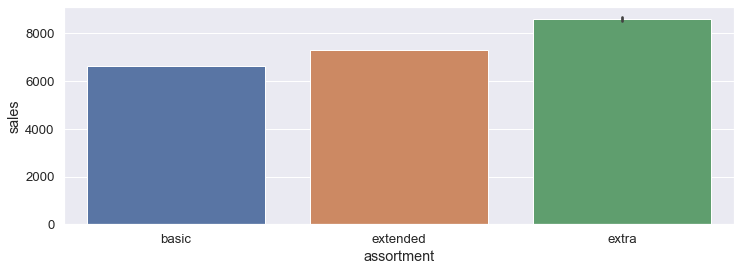

In [38]:
plt.figure(figsize= (12, 4))
sns.barplot(x='assortment', y='sales', data=df4, estimator=np.mean);

Our hypothesis has already been validated. But we will check the behavior over the weeks of the years.

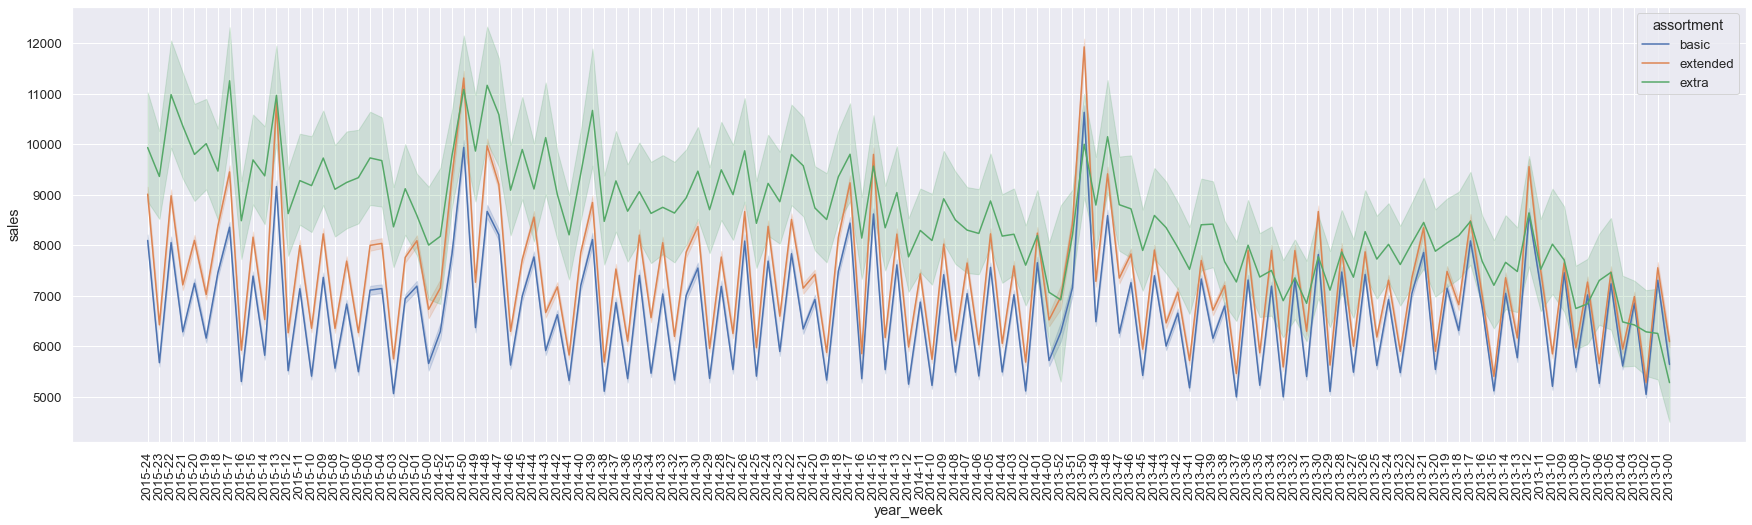

In [39]:
aux1 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()

plt.figure(figsize= (30, 8))
sns.lineplot(x='year_week', y='sales', hue='assortment', data=df4)
plt.xticks(rotation=90);

Basic and extended has a very similar behavior. In some weeks, the average sales of extended exceed those of extra.Note that the standard deviation of the extra is very high compared to the others, that is, the values vary greatly from the average. 

### **H2.** On avarange, stores with closer competitors should sell less.
**False.** Distance from competition does not have a a significant correlation with sales.

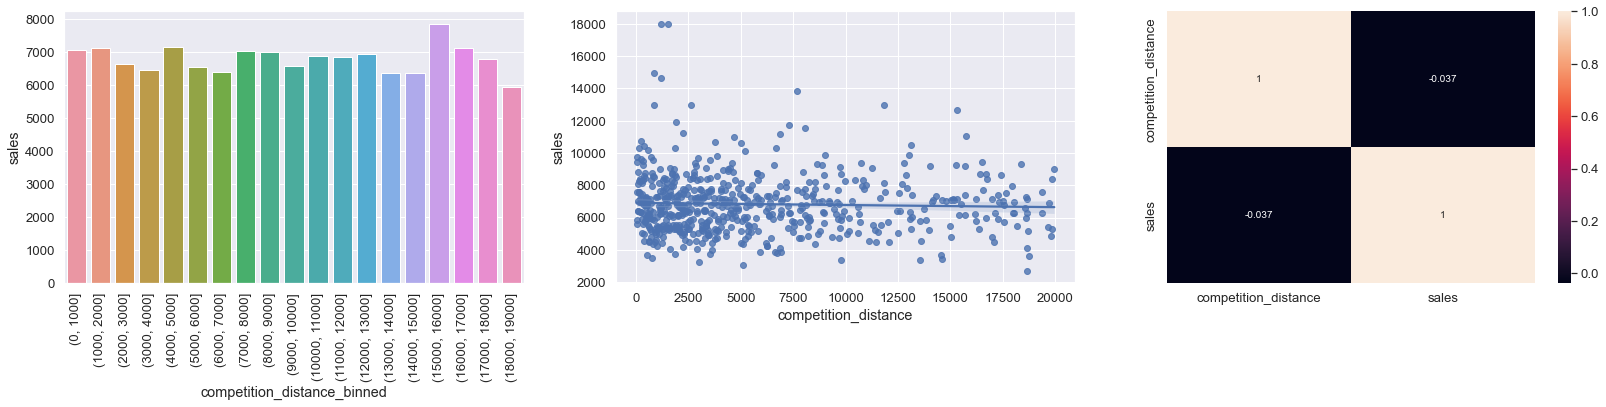

In [40]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()

plt.figure(figsize= (28, 5))

plt.subplot(1, 3, 1)
sns.barplot(x = 'competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
aux3 = aux1[aux1['competition_distance'] <= 20000]         # for better visualization (there are few values after 20000)
sns.regplot(x='competition_distance', y='sales', data=aux3)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Stores with long-term competitors (over 10 years) should sell more.

**True.** Stores with long-term competitors sell more.

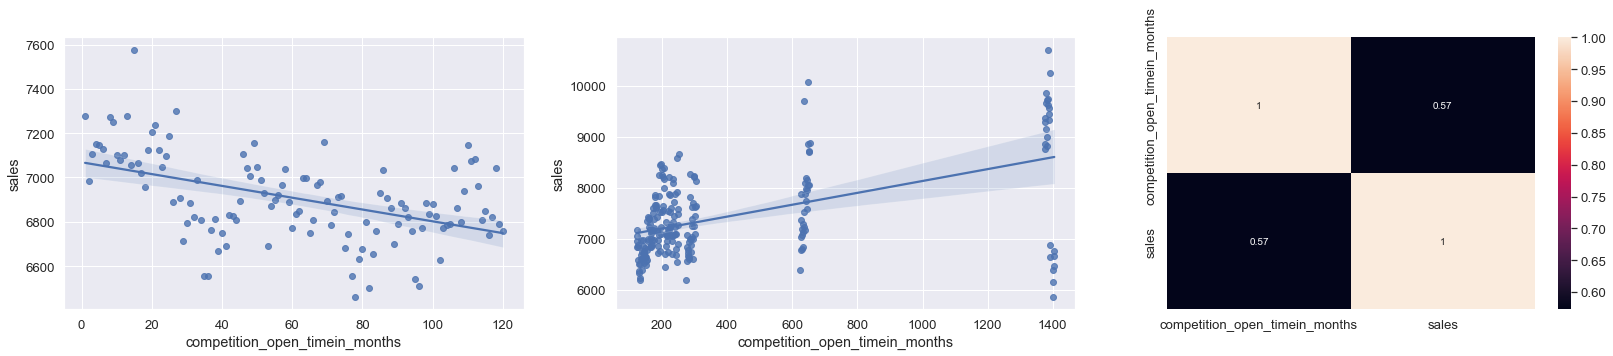

In [41]:
aux1 = df4[['competition_open_timein_months', 'sales']].groupby('competition_open_timein_months').mean().reset_index()
aux3 = aux1[(aux1['competition_open_timein_months'] > 0) & (aux1['competition_open_timein_months'] <= 120)]
aux4 = aux1[ aux1['competition_open_timein_months'] > 120]

plt.figure(figsize= (28, 5))

plt.subplot(1, 3, 1)
sns.regplot(x='competition_open_timein_months', y='sales', data=aux3)

plt.subplot(1, 3, 2)
sns.regplot(x='competition_open_timein_months', y='sales', data=aux4)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.**  On on average, stores with active promotions should sell more.
**True.** Stores with active promotions sell 38.56% more than stores with no promotion.

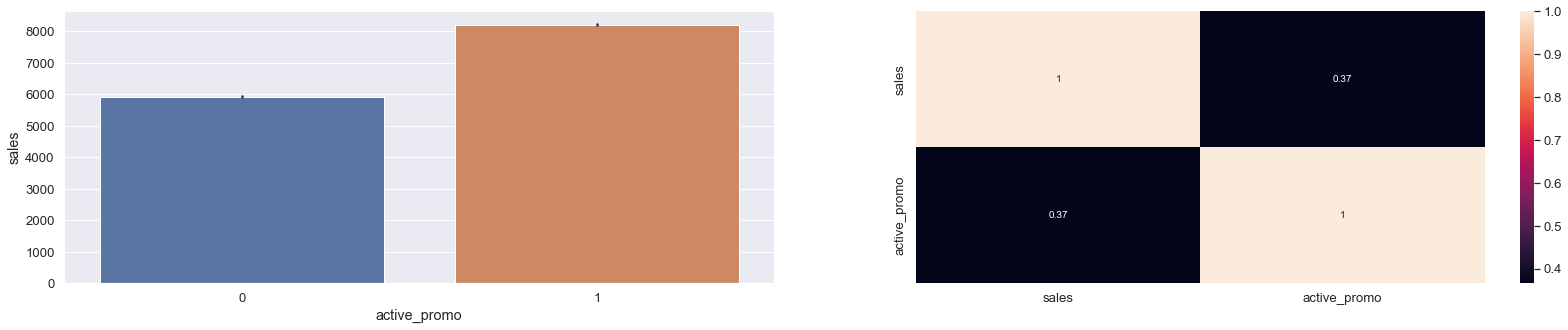

In [42]:
# is_promo  - indicates whether a store is running a promo (other than promo2) on that day.
# is_promo2 - indicates whether a store is running a promo2 on that day (promo2 is a continuing and consecutive promotion for some stores).
aux1 = df4[['store', 'sales', 'is_promo', 'is_promo2']].copy()
aux1['active_promo'] = aux1[['is_promo', 'is_promo2']].apply(lambda x: 0 if (x['is_promo'] == 0 & x['is_promo2']== 0) else 1, axis=1)

plt.figure(figsize= (28, 5))

plt.subplot(1, 2, 1)
sns.barplot(x = 'active_promo', y='sales', data=aux1);

plt.subplot(1, 2, 2)
sns.heatmap(aux1[['sales', 'active_promo']].corr(method='pearson'), annot=True);

In [43]:
aux2 = (aux1.groupby('active_promo').agg(qty_stores = ('store', 'nunique'), avg_sales = ('sales', 'mean'))).reset_index()
display(aux2)

active_promo = aux2.iloc[0,2]
no_promo     = aux2.iloc[1,2]

percentage = abs(((active_promo - no_promo) / no_promo)*100)
print(f' Stores with active promotions sell {percentage:.2f}% more than stores with no promotions.')

,active_promo,qty_stores,avg_sales
0,0,1115,5931.13
1,1,1115,8218.37


 Stores with active promotions sell 27.83% more than stores with no promotions.


### **H5.**  Stores with longer active promo2 should sell more.
**True.** The longer the time in promo2 the higher the average sales.

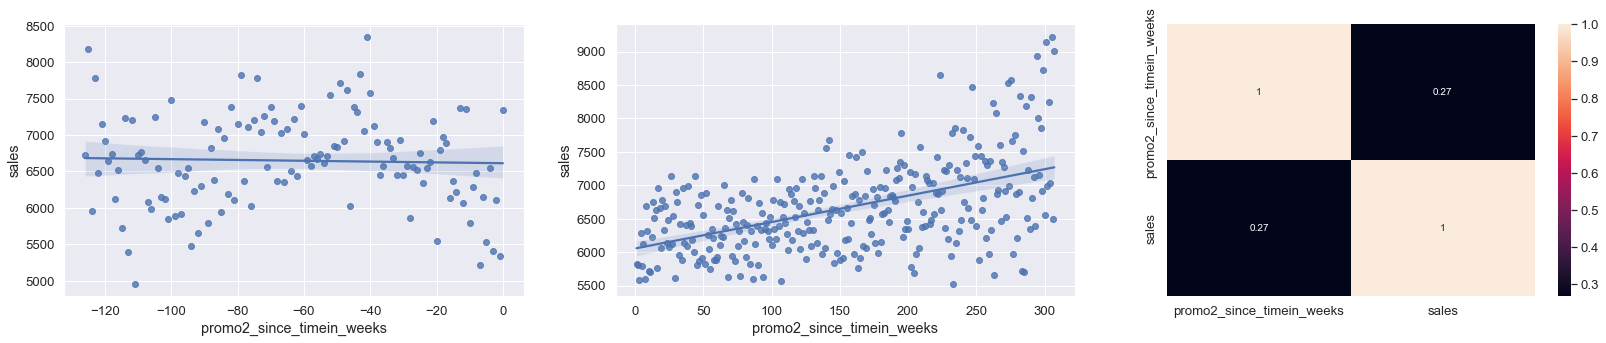

In [44]:
aux1 = df4[['promo2_since_timein_weeks', 'sales']].groupby('promo2_since_timein_weeks').mean().reset_index()

aux2 = aux1[aux1['promo2_since_timein_weeks'] >  0] 
aux3 = aux1[aux1['promo2_since_timein_weeks'] <= 0] 

plt.figure(figsize= (28, 5))

plt.subplot(1, 3, 1)
sns.regplot(x='promo2_since_timein_weeks', y='sales', data=aux3)

plt.subplot(1, 3, 2)
sns.regplot(x='promo2_since_timein_weeks', y='sales', data=aux2)

plt.subplot(1, 3, 3) 
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## -- note:
# negative values for promo2_since_timein_weeks means that promotion happened after sales register.

For the positive values of 'promo2_since_timein_weeks' it is clear from the plot that the longer the time in prom2 the higher the sales, confirming our hypothesis. 

Negative values for 'competition_open_timein_months' means that the competition opened after the sales, and is interesting to take into consideration, when you have marketing actions about something that will happen.

### **H6.** On average, stores that besides continued promotion, also are running another promotion, sell more than stores that are running only the continued promotion.  
**True.** Stores that besides continued and consecutive promotion, also are running another promotion, sell 41.70% more than stores that are running only the continued and consecutive promotion.


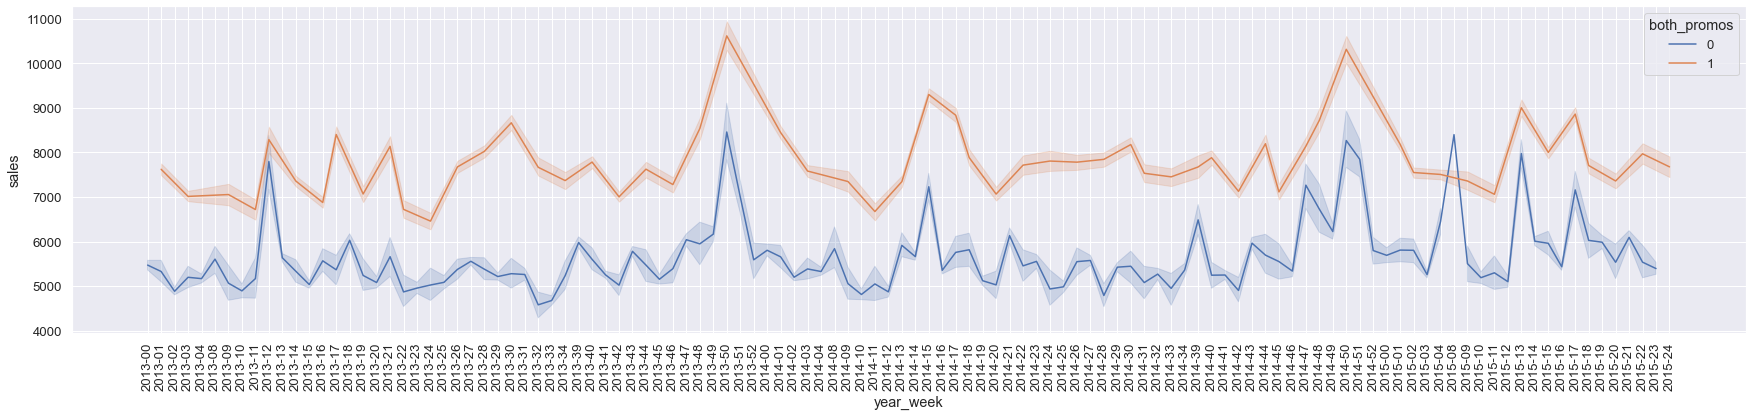

In [45]:
# is_promo  - indicates whether a store is running a promo (other than promo2) on that day.
# is_promo2 - indicates whether a store is running a promo2 on that day (promo2 is a continuing and consecutive promotion for some stores).

aux1 = df4[df4['is_promo2']==1][['store', 'sales', 'is_promo', 'is_promo2', 'year_week']].sort_values('year_week', ascending=True).copy().rename(columns={'is_promo': 'promos'})
aux1['both_promos'] = aux1['promos'].apply(lambda x: 1 if x == 1 else 0 )

plt.figure(figsize= (30, 6))
sns.lineplot(x='year_week', y='sales', hue='both_promos', data=aux1)
plt.xticks(rotation=90);

In [46]:
aux2 = (aux1.groupby('both_promos').agg(qty_stores = ('store', 'nunique'), avg_sales  = ('sales', 'mean'))).reset_index()
display(aux2)

both_promos = aux2.iloc[0,2]
just_promo2 = aux2.iloc[1,2]

percentage = abs(((both_promos - just_promo2) / just_promo2)*100)
print(f' Stores that besides continued and consecutive promotion, also are running another promotion, sell {percentage:.2f}% more than stores that are running only the continued and consecutive promotion.')

,both_promos,qty_stores,avg_sales
0,0,571,5501.37
1,1,571,7795.24


 Stores that besides continued and consecutive promotion, also are running another promotion, sell 29.43% more than stores that are running only the continued and consecutive promotion.


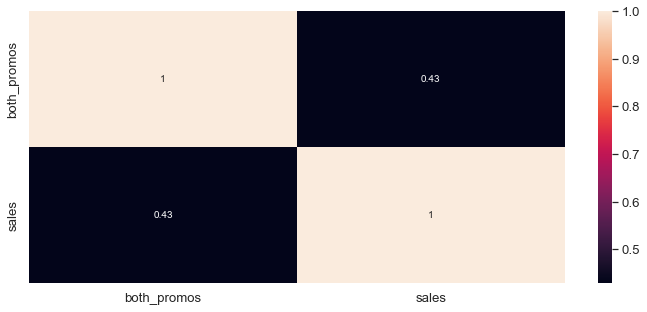

In [47]:
plt.figure(figsize= (12, 5))
sns.heatmap(aux1[['both_promos', 'sales']].corr(method='pearson'), annot=True);

### **H7.** Every year, stores open during the Christmas holiday are expected to sell more on average than during other holidays.
**False.** In 2014 the Christmas holiday sold more than the other holidays, but this did not occur in 2013.

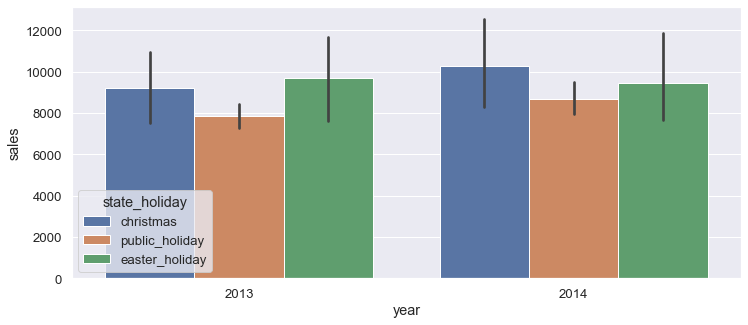

In [48]:
aux1 = df4[(df4['state_holiday'] != 'regular_day') & (df4['year'] != 2015)][['sales', 'state_holiday', 'year']].copy()

plt.figure(figsize= (12, 5))
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux1);

### **H8.** Stores should sell more over years.
**False.** From 2013 to 2014, sales decreased $122071188.00 which represents -5.60%.

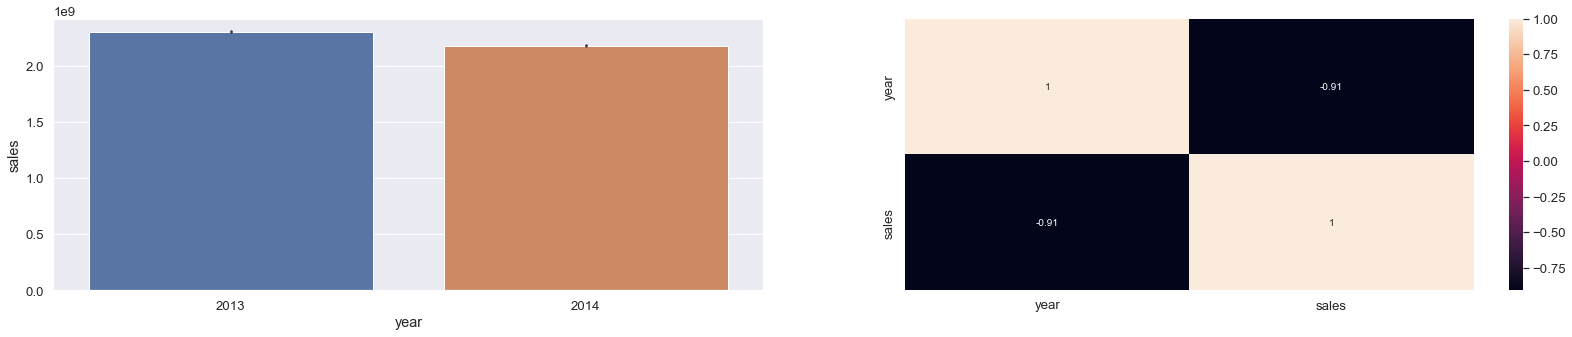

In [49]:
# leaving aside the year 2015 as we have data only for half of the year
aux1 = df4[df4['year'] != 2015][['year','sales', 'store']].copy()

plt.figure(figsize= (28, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='year', y='sales', data=aux1, estimator=np.sum);

aux2 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1, 2, 2) 
sns.heatmap(aux2.corr(method='pearson'), annot=True);

In [50]:
aux2 = (aux1.groupby('year').agg(qty_stores = ('store', 'nunique'), sum_sales = ('sales', 'sum'))).reset_index()
display(aux2)

sales2013 = aux2.iloc[0,2]
sales2014 = aux2.iloc[1,2]

percentage = abs(((sales2013 - sales2014) / sales2014)*100)
print(f'From 2013 to 2014, sales decreased ${(sales2013 - sales2014):.2f} which represents -{percentage:.2f}%')

,year,qty_stores,sum_sales
0,2013,1115,2302876084
1,2014,1115,2180804896


From 2013 to 2014, sales decreased $122071188.00 which represents -5.60%


### **H9.** Stores should sell more in the second half of the year.
**False.** In 2013 stores sold more in the second half, but in 2014 they did not.

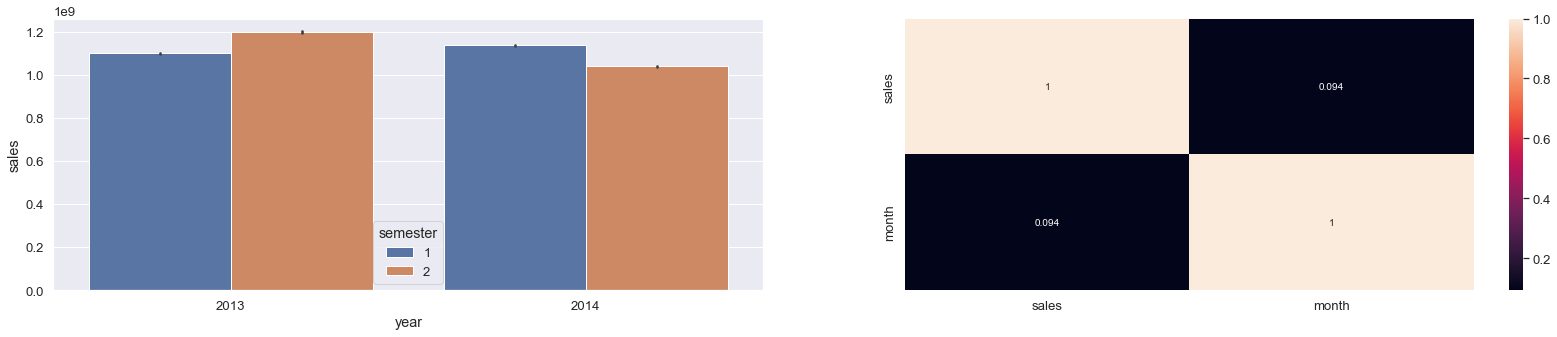

In [51]:
# leaving aside the year 2015 as we have data only for half of the year
aux1 = df4[df4['year'] != 2015][['year', 'month', 'sales', 'store']].copy()

aux1['semester'] = aux1['month'].apply(lambda x: 1 if x <= 6 else 2)

plt.figure(figsize= (28, 5))

plt.subplot(1, 2, 1) 
sns.barplot(x='year', y='sales', hue='semester', data=aux1, estimator=np.sum)

plt.subplot(1, 2, 2) 
sns.heatmap(aux1[['sales', 'month']].corr(method='pearson'), annot=True);

### **H10.** On avarange, stores should sell more after the 10th of each month.
**False.** The stores sell 7.78% more before the 10th.

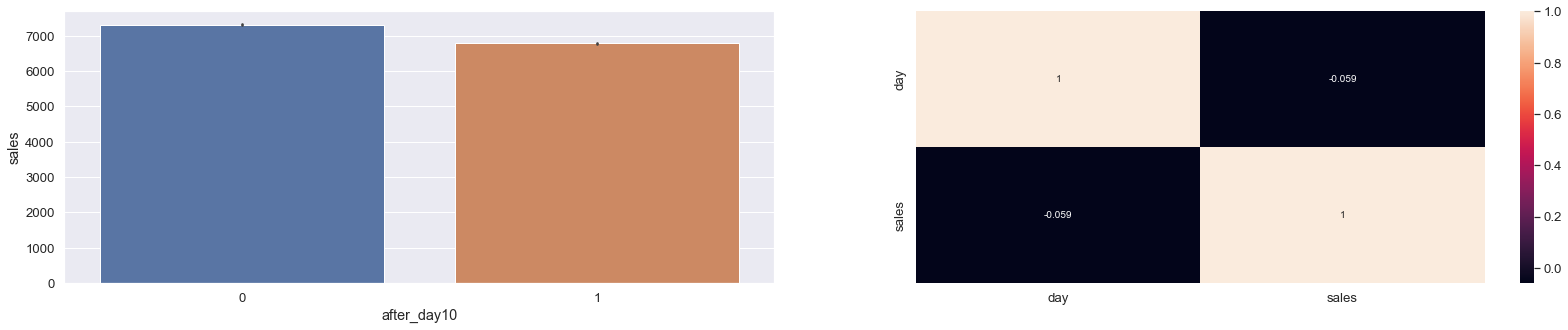

In [52]:
aux1 = df4[['day', 'sales']].copy()

aux1['after_day10'] = aux1['day'].apply(lambda x: 0 if x <= 10 else 1)

plt.figure(figsize= (28, 5))

plt.subplot(1, 2, 1) 
sns.barplot(x='after_day10', y='sales', data=aux1)

plt.subplot(1, 2, 2) 
sns.heatmap(aux1[['day', 'sales']].corr(method='pearson'), annot=True);

In [53]:
aux2 = (aux1.groupby('after_day10').agg(avg_sales = ('sales', 'mean'))).reset_index()
display(aux2)

before_day10 = aux2.iloc[0,1]
after_day10  = aux2.iloc[1,1]

percentage = abs(((before_day10 - after_day10 ) / after_day10 )*100)
print(f'The stores sell {percentage:.2f}% more before the 10th.')

,after_day10,avg_sales
0,0,7310.60
1,1,6782.81


The stores sell 7.78% more before the 10th.


### **H11.** On avarange, stores should sell less on weekends.
**True.** The stores sell 20.64% less on weekends.

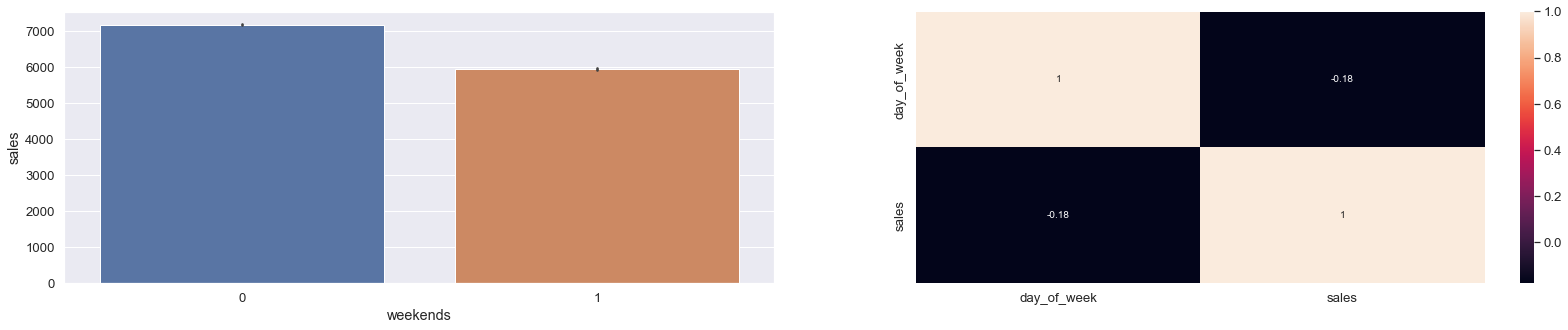

In [54]:
aux1 = df4[['day_of_week', 'sales', 'store']].copy()
aux1['weekends'] = aux1['day_of_week'].apply(lambda x: 0 if x < 6 else 1)

plt.figure(figsize= (28, 5))

plt.subplot(1, 2, 1) 
sns.barplot(x='weekends', y='sales', data=aux1)

plt.subplot(1, 2, 2) 
sns.heatmap(aux1[['day_of_week', 'sales']].corr(method='pearson'), annot=True);

In [55]:
aux2 = (aux1.groupby('weekends').agg(avg_sales = ('sales', 'mean'))).reset_index()
display(aux2)

weekend  = aux2.iloc[0,1]
weekdays = aux2.iloc[1,1]

percentage = abs(((weekdays - weekend) / weekend)*100)
print(f'The stores sell {percentage:.2f}% less on weekends.')

,weekends,avg_sales
0,0,7168.98
1,1,5942.39


The stores sell 17.11% less on weekends.


### **H12**. On avarange, stores should sell less during school holidays.
**False.** The stores sell 3.62% more when it is schooll holidays.

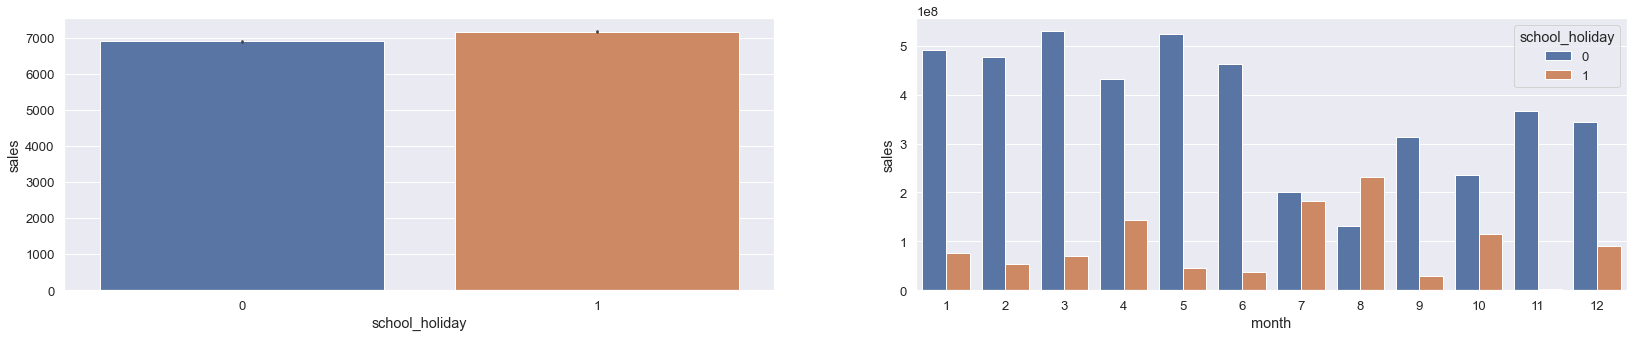

In [56]:
plt.figure(figsize= (28, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=df4);

plt.subplot(1, 2, 2)
aux1 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux1);

In [57]:
aux1 = df4[['school_holiday','sales']].groupby(['school_holiday']).agg(num_sales = ('sales', 'count'), avg_sales = ('sales', 'mean')).reset_index()
display(aux1)

no_school_holiday = aux1.iloc[0,2]
school_holiday    = aux1.iloc[1,2]

percentage = abs(((school_holiday - no_school_holiday) / no_school_holiday)*100)
print(f'The stores sell {percentage:.2f}% more when it is school holidays.')

,school_holiday,num_sales,avg_sales
0,0,652801,6905.40
1,1,150141,7164.98


The stores sell 3.76% more when it is school holidays.


## 4.3 Multivariate Analysis

The goal is not only to see the correlation between the response variable and the predictors, but also between the predictors themselves, to reduce the dimensionality of the model. 

If one variable is highly correlated with another you can take one of them out to reduce the dimensionality of the model. 

### 4.3.1 Numerical Attributes

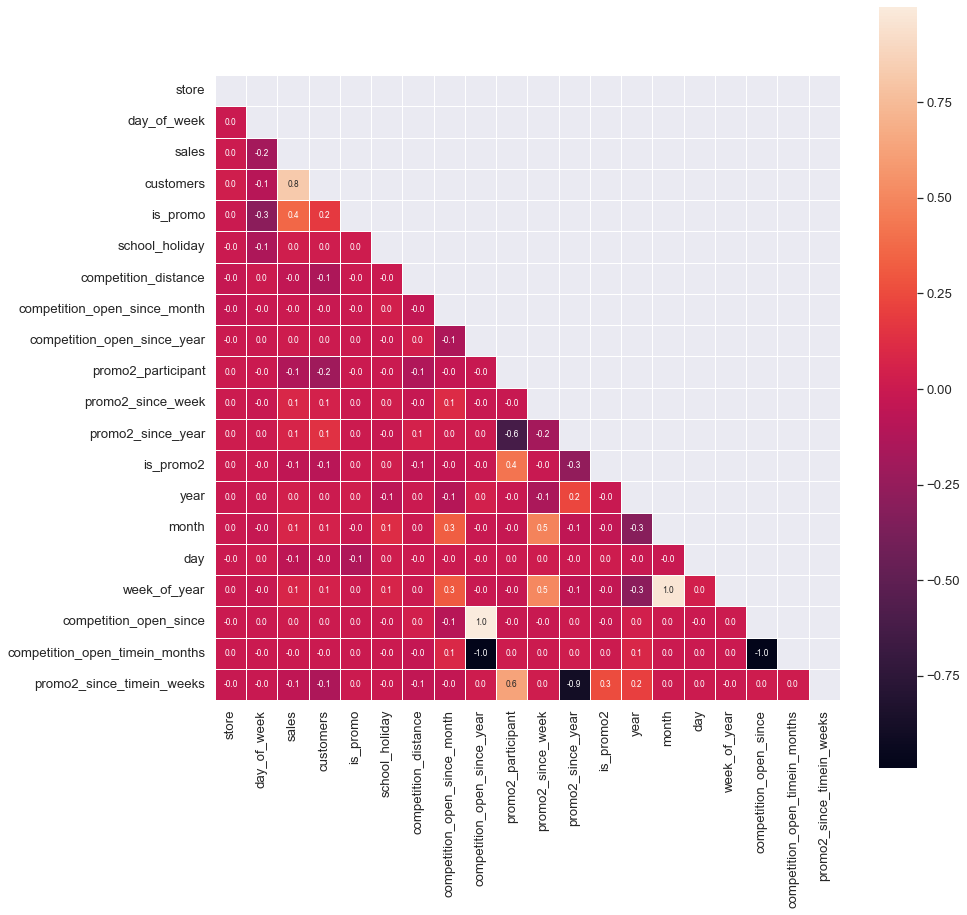

In [58]:
corr = df_num2.corr(method='pearson' )

corr_mask = np.triu(corr)

plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, annot_kws={'fontsize':'small'}, fmt='.1f', linewidths=0.8, square=True, mask=corr_mask);

### 4.3.2 Categorical Attributes

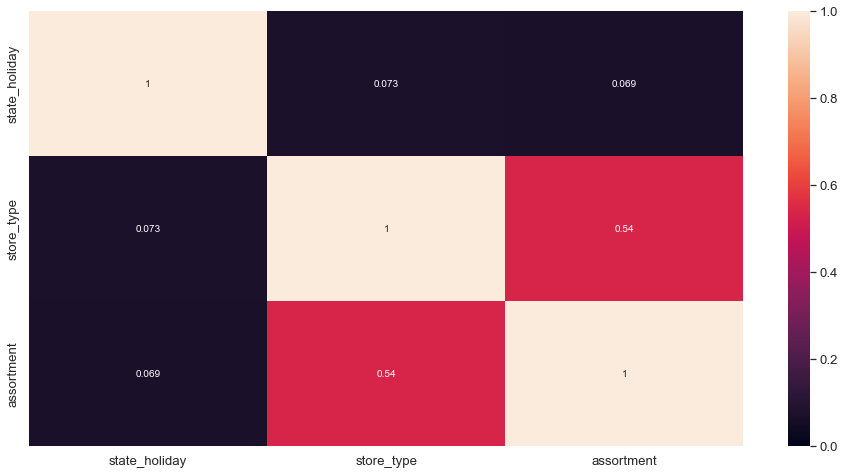

In [61]:
# calculating Cramér's V 
cat = df_cat2.copy()
cat_list = ['state_holiday', 'store_type', 'assortment']
cat_dic = {}


for c1 in cat_list:
    for c2 in cat_list:
        v = cramer_v(cat[c1], cat[c2]) # the cramer_v function is on Helper Functions

        if cat_list.index(c2) == 0:
            cat_dic[c1] = []
            cat_dic[c1].append(v)
        else:
            cat_dic[c1].append(v)


t = pd.DataFrame(cat_dic)
t.set_index(t.columns, inplace=True)

plt.figure(figsize=(16, 8))
sns.heatmap(t, vmin=0, vmax=1, annot=True);